# Markov Model

In this section we will elaborate an analysis using Markov chain theory. The theoretical knowledge come mostly from:

    Introduction to Modeling and Analysis of Stochastic Systems. by, V.G.Kulkami


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
#df = pd.read_excel('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths_taxonomy/sad_with_taxonomy.xlsx')
df = pd.read_csv('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths/sad_log_1Q_inclQ.csv', encoding = "ISO-8859-1")

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:

def transition_matrix(df_id, df_event):
    """
    per session, lets count the sequence of events.
    P is the frequency matrix and PN is the stochastic matrix
    """
    
    events = pd.Series(df_event.unique())
    split = pd.Series(df_id.unique())
    P = pd.DataFrame(0, index= events, columns= events)
    T = pd.DataFrame(0, index= events, columns= events)
    #Calculate the trougthput time
    print('Computing the transition matrix')
    for i in split:
        df_event_temp = df_event[df_id == i]
        if len(df_event_temp) > 1:
            for j in range(1,len(df_event_temp)):
                P.loc[df_event_temp.iloc[j-1],df_event_temp.iloc[j]] += 1
                

    #Create the transition matrix
    print('Normalizing the transition matrix')
    cum_freq = np.sum(P, axis = 0)

    if len(cum_freq[cum_freq == 0]) > 0:
        print('P is NOT an stochastic matrix')
        print('the following values events are deleted:')
        names_out = list(cum_freq[cum_freq == 0].index)
        print(names_out)
        P = P.drop(names_out, axis = 0)
        P = P.drop(names_out, axis = 1)
        print(P.shape)
        
    else: 
        print('P is an stochastic matrix')

    P = P/np.sum(P, axis = 0)
    print('done')
    
    
    return P
    
    
P = transition_matrix(df['sessionid'], df['event'])
    

Computing the transition matrix
Normalizing the transition matrix
P is NOT an stochastic matrix
the following values events are deleted:
['Visit page opzeggen-dienstverband', 'Visit page melding_sha2', 'Visit page onderwijs-overheid', 'Visit page werknemer']
(164, 164)
done


In [4]:
#Export the transition matrix to csv
P.to_csv('transition_matrix.csv')


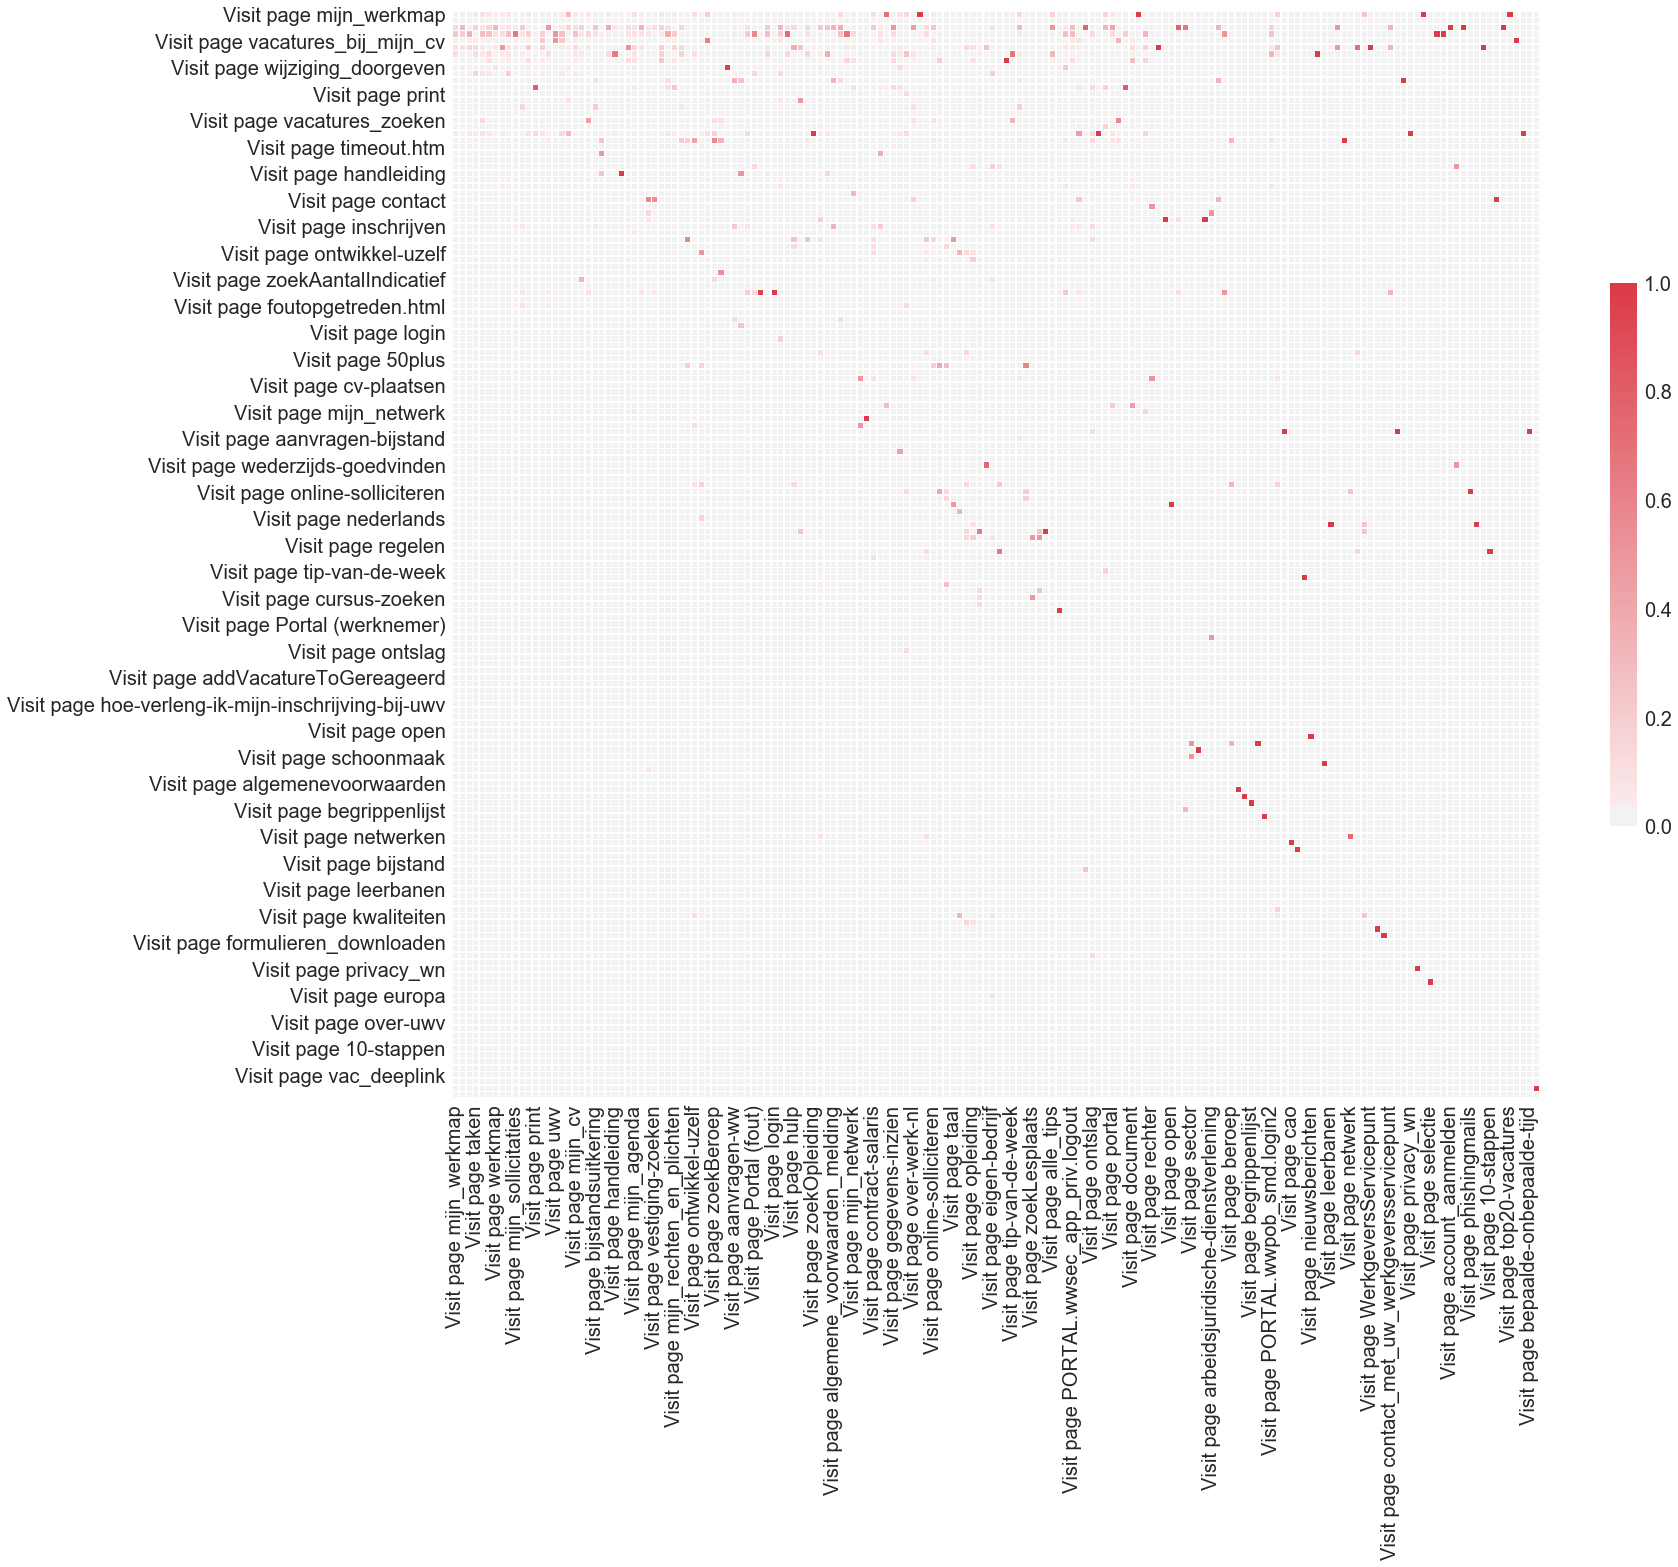

In [15]:
def print_matrix(X):
    mask = np.zeros_like(X, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(25, 20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(X, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    mpl.pyplot.savefig('figures/Transition_matrix.png')
    plt.show()  
    
print_matrix(P)



# Dynamic Effect of the initial State on Users questions using Marconian Properties.

In this section we try to find patterns that eventually will lead to questions.


In [6]:

def create_stepwise_probabilities(P, n_steps, target):
    """
    P is the transition matrix, n_steps are the number of steps that must be considered to reach the target.
    """
    
    P_steps = pd.DataFrame()
    events = list(P)
    for step in range(n_steps):
        P_temp = pd.DataFrame(P[target])
        P_temp['step'] = step + 1
        P = pd.DataFrame(np.dot(P,P), index= events, columns= events)        
        P_steps = pd.concat([P_steps,P_temp],axis=0)

    P_steps['event'] = P_steps.index
    
    P_steps.columns = ['P', 'step', 'event']
    return P_steps.reset_index(drop=True), P
   
P_steps, PN = create_stepwise_probabilities(P.copy(),4 ,'Question')

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


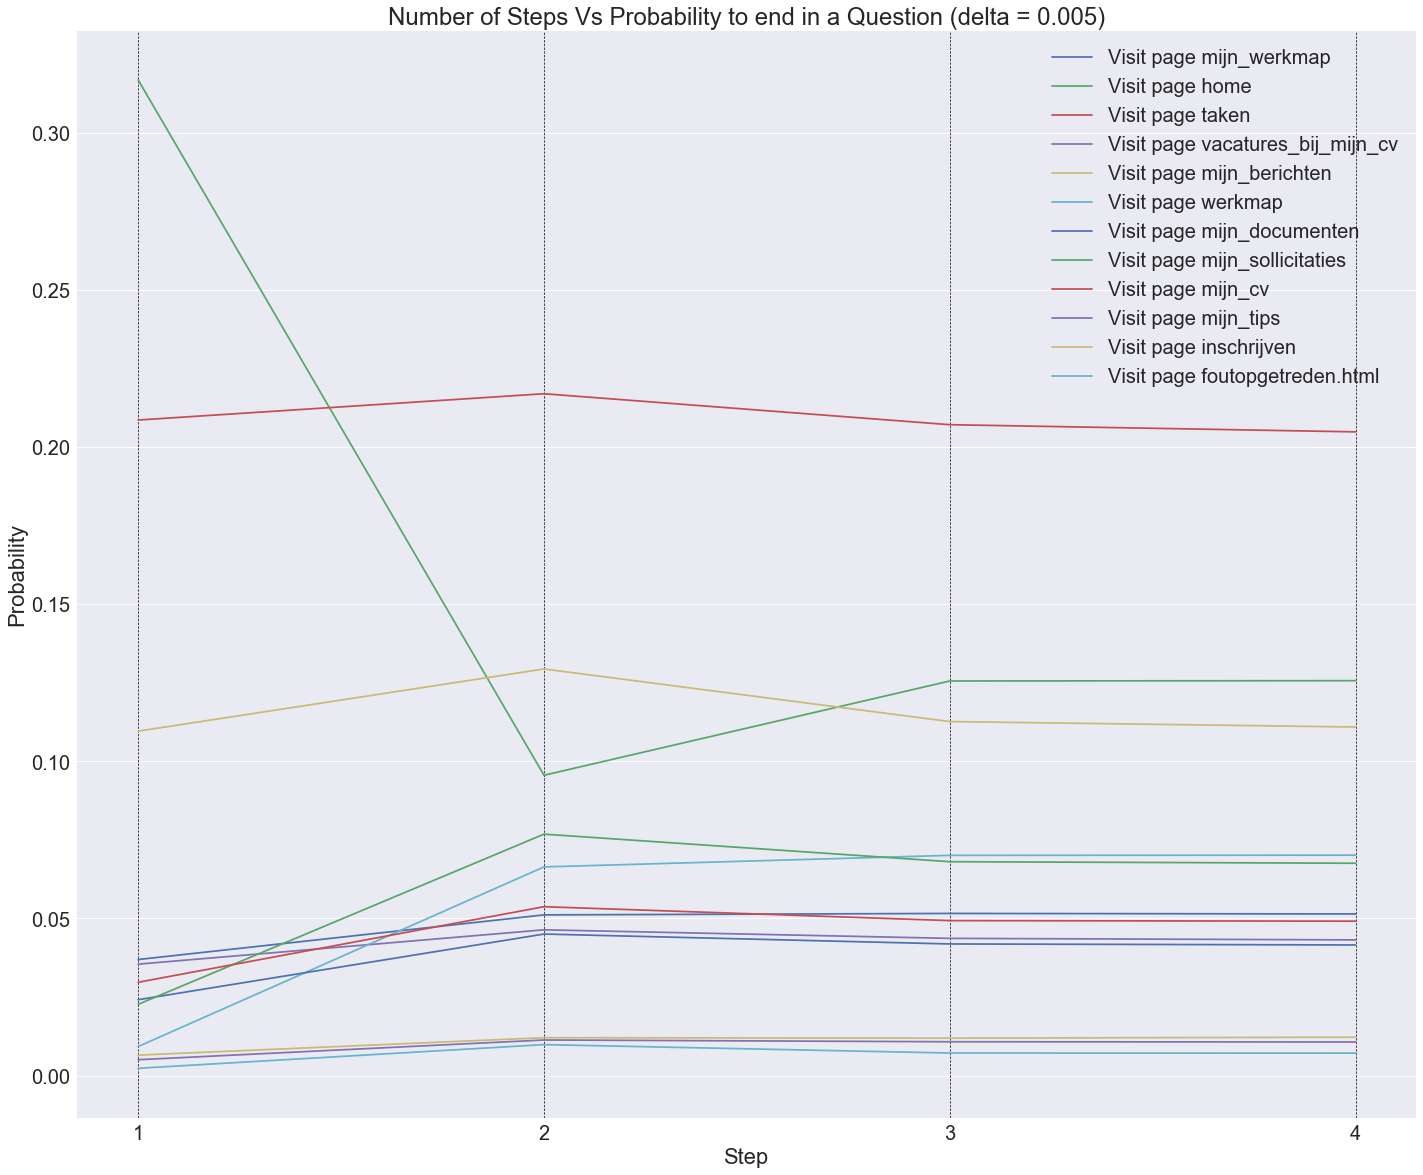

In [28]:
def plot_stepwise_prob(P_steps, threshold, delta = False):
    """
    Plot how the probabilities of different steps change in time. Only take into account events that have a max probability
    bigger than the threshold
    """
    
    #Filter Events
    if delta == False:    
        filter_ = P_steps.groupby(['event'])['P'].max()

    
    else:
        filter_ = pd.DataFrame()
        events = list(P_steps['event'].unique())
        #Calculate delta 
        for event in events:
            P_steps_temp = P_steps[ P_steps['event'] == event]
            P_steps_temp['delta'] = P_steps_temp['P'].diff().dropna()
            filter_temp = P_steps_temp.groupby(['event'])['delta'].max()
            filter_ = pd.concat([filter_, filter_temp],axis=0)
            
    
    filter_ = filter_[filter_.values >= threshold]
    names_in = list(filter_.index)
    P_steps = P_steps[P_steps['event'].isin(names_in)]   
        
    #Create the graph
    sns.set(font_scale=2)
    f, ax = plt.subplots(figsize=(24, 20))
    ax.set_title('Number of Steps Vs Probability to end in a Question (delta = {})'.format(str(threshold)))

    for st in list(P_steps['step'].unique()):
        ax.axvline(x=st,color='black', linestyle='--', linewidth=0.7)
    
    
    for event in list(P_steps['event'].unique()):
        temp_P = P_steps[P_steps['event'] == event]
        ax.plot(temp_P['step'], temp_P['P'], label = event)

    ax.legend(loc='upper right')
    ax.set(xlabel='Step', ylabel='Probability')    
    plt.xticks(list(P_steps['step'].unique()))
    
    mpl.pyplot.savefig('figures/trigger_events.png')
    plt.show()
    
    return P_steps
    
P_temp = plot_stepwise_prob(P_steps, 0.005, True)


In [8]:
#P_temp = plot_stepwise_prob(P_steps, 0.05, False)

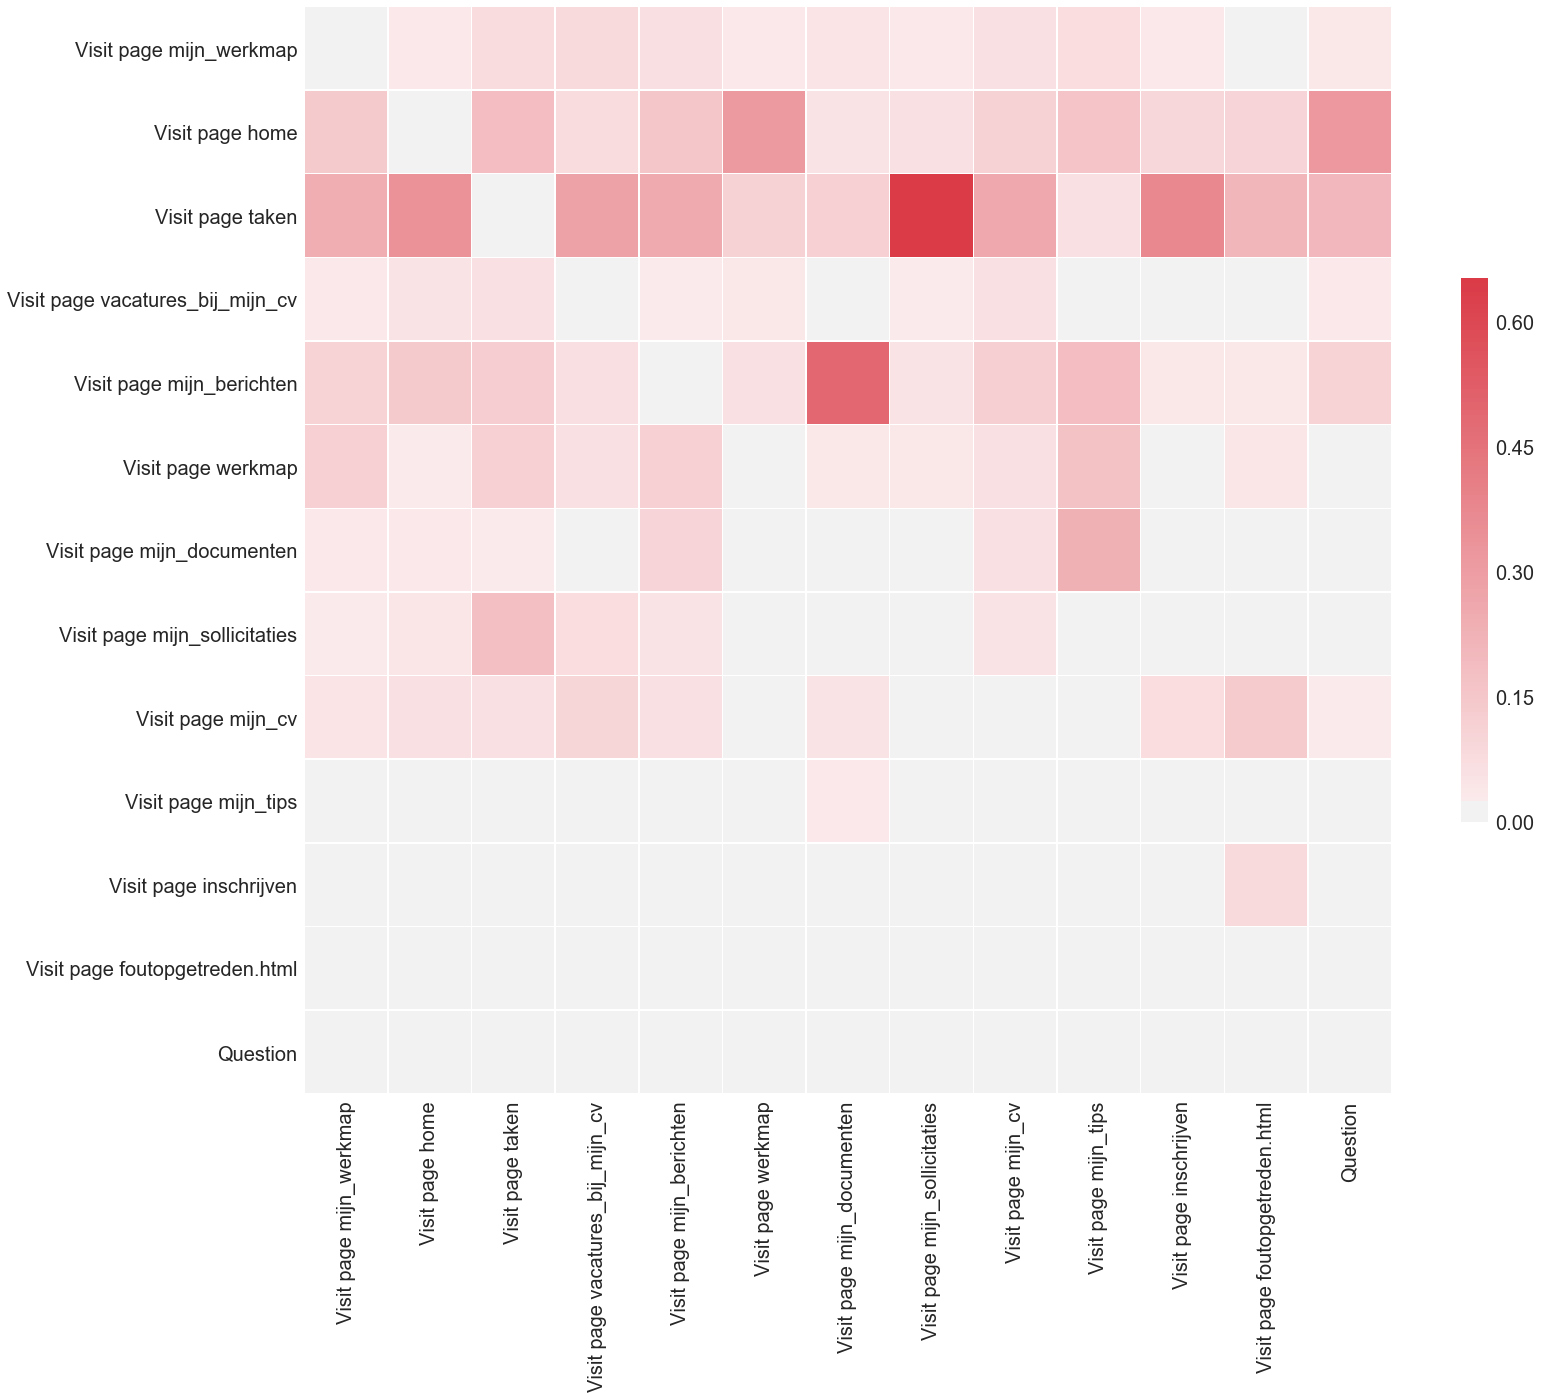

In [13]:
#Transition Matrix of the events that may trigger questions
sig_events = list(P_temp['event'].unique())
sig_events.append('Question')
print_matrix(P.loc[sig_events,sig_events])

,P,step,event
0,0.036924,1,Visit page mijn_werkmap
2,0.316899,1,Visit page home
3,0.208644,1,Visit page taken
4,0.035456,1,Visit page vacatures_bij_mijn_cv
5,0.109619,1,Visit page mijn_berichten
